https://pub.towardsai.net/how-to-create-a-siamese-network-with-keras-to-compare-images-5713b3ee7a28

Notebook: https://www.kaggle.com/code/peremartramanonellas/how-to-create-a-siamese-network-to-compare-images#Creating-the-Siamese-Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
np.random.seed(123)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline
import cv2
from google.colab.patches import cv2_imshow
from glob import glob
from tqdm import tqdm
import os


# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import resnet

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately,
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.12.0
keras version 2.12.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
GPU Available:  []
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
!nvidia-smi

Sat Apr 22 19:32:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    28W /  70W |    375MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data

- identity data

- unzip & import images

- prepare training data for siamese network with input being (img1, img2) and label = 1 or 0 (indicating the same person or not)

- organize everything in tensorflow format

In [ ]:
!unzip /content/drive/MyDrive/Facial_Recognition_Project/CelebA/img_align_celeba.zip > /dev/null

In [ ]:
identity_df = pd.read_csv('/content/drive/MyDrive/Facial_Recognition_Project/CelebA/identity_CelebA.txt', sep=' ', header=None)
identity_df = identity_df.rename(columns={0:'image', 1:'ID'})
identity_df.head()

,image,ID
0,000001.jpg,2880
1,000002.jpg,2937
2,000003.jpg,8692
3,000004.jpg,5805
4,000005.jpg,9295


(218, 178, 3)


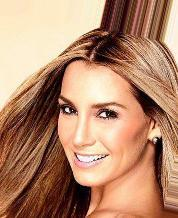

In [ ]:
img = cv2.imread('img_align_celeba/000001.jpg')
print(img.shape)
cv2_imshow(img)

In [ ]:
# Input Images
data_img = glob('img_align_celeba/*.jpg')
print("Image count:",len(data_img))
print(data_img[:5])

Image count: 202599
['img_align_celeba/158169.jpg', 'img_align_celeba/155412.jpg', 'img_align_celeba/077650.jpg', 'img_align_celeba/109323.jpg', 'img_align_celeba/029503.jpg']


In [ ]:
def make_pairs_label(data_img, identity_df, pos_size=7000, neg_size=25000):
    def positive_pairs(data_img, identity_df, size):
        df = []
        identity_group_df = identity_df.groupby('ID')['image'].apply(list).reset_index(name='grouped')
        while len(df) < size:
            grouped_list = identity_group_df.sample()['grouped'].tolist()[0]
            if len(grouped_list) < 2:
                continue
            img1_name, img2_name = np.random.choice(grouped_list, size=2, replace=False)
            img1 = 'img_align_celeba/' + img1_name
            img2 = 'img_align_celeba/' + img2_name
            identity1 = identity_df[identity_df['image'] == img1_name]['ID'].item()
            identity2 = identity_df[identity_df['image'] == img2_name]['ID'].item()
            label = int(identity1 == identity2)
            assert label == 1
            # update df
            if int(img1_name[:6]) < int(img2_name[:6]):
                df.append([img1, img2, label])
            else:
                df.append([img2, img1, label])
        df = pd.DataFrame(df, columns=['X1', 'X2', 'label'])
        return df

    def negative_pairs(data_img, identity_df, size):
        df = []
        while len(df) < size:
            img1, img2 = np.random.choice(data_img, size=2, replace=False)
            img1_name = img1.split('/')[-1]
            img2_name = img2.split('/')[-1]
            identity1 = identity_df[identity_df['image'] == img1_name]['ID'].item()
            identity2 = identity_df[identity_df['image'] == img2_name]['ID'].item()
            label = int(identity1 == identity2)
            if label == 0:
                # update df
                if int(img1_name[:6]) < int(img2_name[:6]):
                    df.append([img1, img2, label])
                else:
                    df.append([img2, img1, label])
        df = pd.DataFrame(df, columns=['X1', 'X2', 'label'])
        return df

    # typically random sampling from the entire dataset gives us negative pairs
    neg_df = negative_pairs(data_img, identity_df, neg_size)
    print('Negative pairs ready!')
    # it is very different to get positive pairs the same way
    pos_df = positive_pairs(data_img, identity_df, pos_size)
    print('Positive pairs ready!')
    df = pd.concat([pos_df, neg_df])
    df.drop_duplicates(inplace=True)
    df = df.sample(frac=1).reset_index(drop=True) # shuffle and reindex
    return df

paired_data_path = '/content/drive/MyDrive/Facial_Recognition_Project/CelebA/paired_data_7k14k.csv'

if os.path.exists(paired_data_path):
    paired_data_df = pd.read_csv(paired_data_path)
'''
else:
    paired_data_df = make_pairs_label(data_img, identity_df) #, pos_size=7000, neg_size=14000)
    # save df so that we don't have to rerun every time
    paired_data_df.to_csv(paired_data_path)
'''

paired_data_df.head(10)

,Unnamed: 0,X1,X2,label
0,0,img_align_celeba/048896.jpg,img_align_celeba/090218.jpg,0
1,1,img_align_celeba/046028.jpg,img_align_celeba/066430.jpg,1
2,2,img_align_celeba/056916.jpg,img_align_celeba/143847.jpg,1
3,3,img_align_celeba/003954.jpg,img_align_celeba/007730.jpg,0
4,4,img_align_celeba/134503.jpg,img_align_celeba/170323.jpg,0
5,5,img_align_celeba/003129.jpg,img_align_celeba/085998.jpg,0
6,6,img_align_celeba/003710.jpg,img_align_celeba/117620.jpg,0
7,7,img_align_celeba/082721.jpg,img_align_celeba/194865.jpg,0
8,8,img_align_celeba/111931.jpg,img_align_celeba/196059.jpg,0
9,9,img_align_celeba/165927.jpg,img_align_celeba/182374.jpg,1


In [ ]:
paired_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20898 entries, 0 to 20897
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  20898 non-null  int64 
 1   X1          20898 non-null  object
 2   X2          20898 non-null  object
 3   label       20898 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 653.2+ KB


In [ ]:
image_width = 224
image_height = 224
num_channels = 3
num_output_masks = 2
batch_size = 4

# Load Image
def load_image(input_paths, label):
    input_path1, input_path2 = input_paths[0], input_paths[1]
    input_image1 = tf.io.read_file(input_path1)
    input_image1 = tf.image.decode_jpeg(input_image1, channels=num_channels)
    input_image2 = tf.io.read_file(input_path2)
    input_image2 = tf.image.decode_jpeg(input_image2, channels=num_channels)
    return (input_image1, input_image2), label

# preprocessing - Scale pixels
def scale_image_pixels(input_images, label):
    input_image1, input_image2 = input_images[0], input_images[1]
    input_image1 = tf.cast(input_image1, tf.float32)
    input_image1 = input_image1/255.0
    input_image2 = tf.cast(input_image2, tf.float32)
    input_image2 = input_image2/255.0
    return (input_image1, input_image2), label
#tf.cast(train_labels, tf.float32)
#dataset = tf.data.Dataset.from_tensor_slices((paired_data_df[['X1', 'X2']], paired_data_df['label']))
dataset = tf.data.Dataset.from_tensor_slices((paired_data_df[['X1', 'X2']], paired_data_df['label'].to_numpy(dtype=np.float32)))
dataset = dataset.shuffle(buffer_size=len(dataset) * 3)
dataset = dataset.map(load_image, num_parallel_calls=AUTOTUNE)
dataset = dataset.map(scale_image_pixels, num_parallel_calls=AUTOTUNE)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(AUTOTUNE)
print("dataset", dataset)

dataset <_PrefetchDataset element_spec=((TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


x1.shape [(4, 218, 178, 3) (4, 218, 178, 3)]
y1.shape (4,)

In [ ]:
for x_, y_ in dataset.take(2):
    x1_, x2_ = x_
    print(x1_.shape, x2_.shape)
    print(y_.shape)

(4, 218, 178, 3) (4, 218, 178, 3)
(4,)
(4, 218, 178, 3) (4, 218, 178, 3)
(4,)


In [ ]:
y_

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 0., 0., 0.], dtype=float32)>

In [ ]:
(input_image1, input_image2), label = scale_image_pixels(x_, y_)

In [ ]:
input_image2.shape

TensorShape([4, 218, 178, 3])

In [ ]:
x_[0].shape

TensorShape([4, 218, 178, 3])

# Siamese Model

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(sum_square)
    #return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def initialize_base_branch():
    input = Input(shape=(218,178,3), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.3, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.3, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)
    #Returning a Model, with input and outputs, not just a group of layers.
    return Model(inputs=input, outputs=x)

#Conv2D(filters=64,kernel_size=(3, 3),padding='same',activation='relu',name='conv9_1_3x3')(up9)
def initialize_conv_layer():
    input = Input(shape=(218,178,3), name="base_input")
    x = Conv2D(filters=64,kernel_size=(3, 3),padding='same',activation='relu',name='conv1_3x3')(input)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)

    x = Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu',name='conv2_3x3')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)

    x = Conv2D(filters=16,kernel_size=(3, 3),padding='same',activation='relu',name='conv3_3x3')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)

    x = Flatten(name="flatten_input")(x)

    x = Dense(128, activation='relu', name="third_base_dense")(x)
    #Returning a Model, with input and outputs, not just a group of layers.
    return Model(inputs=input, outputs=x)

#for this one it is necessary to resize the images
def initialize_resnet_backbone():
  base_cnn = resnet.ResNet50(
      weights="imagenet", input_shape=(218, 178, 3), include_top=False
    )

  flatten = Flatten()(base_cnn.output)
  dense1 = Dense(512, activation="relu")(flatten)
  dense1 = BatchNormalization()(dense1)
  dense2 = Dense(256, activation="relu")(dense1)
  dense2 = BatchNormalization()(dense2)
  output = Dense(256)(dense2)

  embedding = Model(base_cnn.input, output, name="Embedding")

  trainable = False
  for layer in base_cnn.layers:
      if layer.name == "conv5_block1_out":
          trainable = True
      layer.trainable = trainable

  return embedding

#base_model = initialize_base_branch()
base_model = initialize_resnet_backbone()

#Left embedding
input_l = Input(shape=(218, 178,3), name='left_input')
vect_output_l = base_model(input_l)

#Right embedding
input_r = Input(shape=(218, 178,3), name='right_input')
vect_output_r = base_model(input_r)

#Embeddings and calculate the euclidean distance
output = Lambda(euclidean_distance, name='output_layer',
                output_shape=eucl_dist_output_shape)([vect_output_l, vect_output_r])

model = Model([input_l, input_r], output)

94765736/94765736 [==============================] - 0s 0us/step


base_mode(image)

base_model(img1), base_mode(img2) -> emb_1, emb_2 ->

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_input (InputLayer)       [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 Embedding (Functional)         (None, 256)          67828608    ['left_input[0][0]',             
                                                                  'right_input[0][0]']        

In [ ]:
model.predict([x1_[0][None, :, :, :], x1_[0][None, :, :, :]])

1/1 [==============================] - 2s 2s/step


array([[0.]], dtype=float32)

In [ ]:
model.predict([x1_[0][None, :, :, :], x1_[1][None, :, :, :]])

1/1 [==============================] - 1s 571ms/step


array([[2.3957472]], dtype=float32)

In [ ]:
y_

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 1., 0., 0.], dtype=float32)>

In [ ]:
x1_.shape

TensorShape([4, 218, 178, 3])

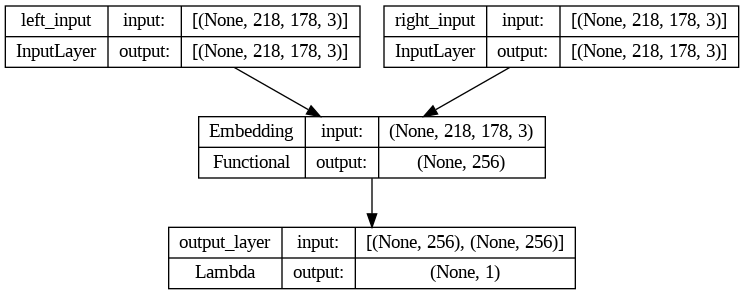

In [ ]:
tf.keras.utils.plot_model(model, to_file='siamese_model.png', show_shapes=True)

In [ ]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

#model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=Adam(learning_rate=0.00005)) #model 10 epoch, lr=0.00005
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=Adam(learning_rate=0.00001))

In [ ]:
history = model.fit(dataset, epochs=10, batch_size=batch_size)

Epoch 1/10
5225/5225 [==============================] - 372s 69ms/step - loss: 5.4254
Epoch 2/10
5225/5225 [==============================] - 354s 68ms/step - loss: 0.2848
Epoch 3/10
5225/5225 [==============================] - 353s 68ms/step - loss: 0.2782
Epoch 4/10
5225/5225 [==============================] - 352s 67ms/step - loss: 0.2917
Epoch 5/10
5225/5225 [==============================] - 351s 67ms/step - loss: 0.2836
Epoch 6/10
5225/5225 [==============================] - 359s 69ms/step - loss: 0.2801
Epoch 7/10
5225/5225 [==============================] - 371s 71ms/step - loss: 0.2722
Epoch 8/10
5225/5225 [==============================] - 355s 68ms/step - loss: 0.2714
Epoch 9/10
5225/5225 [==============================] - 352s 67ms/step - loss: 0.2666
Epoch 10/10
5225/5225 [==============================] - 352s 67ms/step - loss: 0.2661


# Model evaluation

In [ ]:
model.load_weights('/content/drive/MyDrive/Facial_Recognition_Project/Model/resnet_model_epoch10.hp5')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_input (InputLayer)       [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 Embedding (Functional)         (None, 256)          67828608    ['left_input[0][0]',             
                                                                  'right_input[0][0]']        

In [ ]:
for x, y in dataset.take(1):
    test_x1, test_x2 = x

In [ ]:
model.layers

In [ ]:
model.get_layer(index = 2)

In [ ]:
embedding_model = keras.Model(model.input, model.get_layer(index = 2))

ValueError: ignored

In [ ]:
embedding_model.predict(x[0][0][None, :, :, :]).shape

1/1 [==============================] - 0s 44ms/step


(1, 218, 178, 3)

In [ ]:
x = dataset.take(1)

In [ ]:
anchor_embedding = base_model.predict(x[0][0][None, :, :, :])
positive_embedding = base_model.predict(x[1][0][None, :, :, :])
negative_embedding = base_model.predict(x[1][1][None, :, :, :])

1/1 [==============================] - 0s 33ms/step


In [ ]:
anchor_embedding = base_model.predict(x_[0][0][None, :, :, :])
positive_embedding = base_model.predict(x_[1][0][None, :, :, :])
negative_embedding = base_model.predict(x_[1][1][None, :, :, :])

1/1 [==============================] - 0s 22ms/step


In [ ]:
cosine_similarity = keras.metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: -0.17041102
Negative similarity 0.2359793


In [ ]:
model.predict(x)

1/1 [==============================] - 2s 2s/step


array([[0.65323156],
       [0.92969614],
       [0.8617545 ],
       [0.8571671 ]], dtype=float32)

In [ ]:
y

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>

In [ ]:
model.save_weights('/content/drive/MyDrive/Facial_Recognition_Project/Model/resnet_model_epoch10.hp5')

In [ ]:
y_

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 0., 0., 0.], dtype=float32)>

# Testing with all Bradley Cooper images

In [ ]:
from PIL import Image
from tqdm import tqdm

def face_verification(face_db_path, test_img_path):
    test_img = preprocess_image_for_test(test_img_path)
    distances, similatiries, user_names = [], [], []
    #if not os.path.exists(face_db_path):
    #    raise FileNotFoundError('Face database path not found!')
    #for root, dirs, files in os.walk(face_db_path):
    embedding_model = keras.Model(model.input[0], model.get_layer(index = 0).output )
    right_emb = embedding_model.predict(test_img)

    for file_ in tqdm(face_db_path):
        if file_ == test_img_path:
            continue
        left_image = preprocess_image_for_test(file_)
        distance = model.predict([left_image.reshape((1, 218, 178, 3)), test_img.reshape((1, 218, 178, 3))], verbose=0)
        right_emb = embedding_model.predict(left_image)
        similarity = cosine_similarity(left_image, right_emb)
        similatiries.append(similarity.item())

        distances.append(distance[0][0])
        user_names.append(file_.split('.')[0].split('/')[-1])
    predicted_name = user_names[np.argmin(similatiries)]
    return predicted_name, distances, similatiries, user_names

def preprocess_image_for_test(path):
    img = Image.open(path)
    img = img.resize((218, 178))
    img = img.convert("RGB")
    img = np.asarray(img) / 255.0
    img = img[:, :, :3]
    return img
# test_img = '/content/drive/MyDrive/AC221/Facial_Recognition_Project/test_faces/biden_test.jpeg'
# preprocess_image_for_test(test_img)

In [ ]:
celebs = pd.read_csv('/content/drive/MyDrive/Facial_Recognition_Project/CelebA/list_identity_celeba.txt', sep='   ')
celebs

<ipython-input-69-c6b12f95721a>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  celebs = pd.read_csv('/content/drive/MyDrive/Facial_Recognition_Project/CelebA/list_identity_celeba.txt', sep='   ')


,image_id,identity_name
0,000001.jpg,Elizabeth_Gutierrez
1,000002.jpg,Emilia_Fox
2,000003.jpg,Shane_Harper
3,000004.jpg,Leonor_Varela
4,000005.jpg,Tatana_Kucharova
...,...,...
202594,202595.jpg,Veronica_Varekova
202595,202596.jpg,Nathan_Gamble
202596,202597.jpg,Vivek_Oberoi
202597,202598.jpg,Kyle_Richards


In [ ]:
target_celeb = 'Bradley_Cooper'
images_path = ['img_align_celeba/' + img_id for img_id in celebs[celebs.identity_name == target_celeb]['image_id'].values]
images_path

['img_align_celeba/164840.jpg',
 'img_align_celeba/165109.jpg',
 'img_align_celeba/165404.jpg',
 'img_align_celeba/169437.jpg',
 'img_align_celeba/170720.jpg',
 'img_align_celeba/170949.jpg',
 'img_align_celeba/171195.jpg',
 'img_align_celeba/172694.jpg',
 'img_align_celeba/173445.jpg',
 'img_align_celeba/175386.jpg',
 'img_align_celeba/175421.jpg',
 'img_align_celeba/175602.jpg',
 'img_align_celeba/176118.jpg',
 'img_align_celeba/176321.jpg',
 'img_align_celeba/176371.jpg',
 'img_align_celeba/178444.jpg',
 'img_align_celeba/179086.jpg',
 'img_align_celeba/180632.jpg',
 'img_align_celeba/181356.jpg',
 'img_align_celeba/181377.jpg']

In [ ]:
predicted_name, distances, user_names = face_verification(images_path, images_path[0])

1/1 [==============================] - 0s 52ms/step
distance: [[0.2418532]]
1/1 [==============================] - 0s 75ms/step
distance: [[0.21688248]]
1/1 [==============================] - 0s 88ms/step
distance: [[0.2760787]]
1/1 [==============================] - 0s 55ms/step
distance: [[0.20494094]]
1/1 [==============================] - 0s 79ms/step
distance: [[0.39615977]]
1/1 [==============================] - 0s 43ms/step
distance: [[0.38304982]]
1/1 [==============================] - 0s 43ms/step
distance: [[0.31326574]]
1/1 [==============================] - 0s 41ms/step
distance: [[0.4006151]]
1/1 [==============================] - 0s 64ms/step
distance: [[0.27643174]]
1/1 [==============================] - 0s 41ms/step
distance: [[0.29109508]]
1/1 [==============================] - 0s 49ms/step
distance: [[0.37771755]]
1/1 [==============================] - 0s 45ms/step
distance: [[0.33139092]]
1/1 [==============================] - 0s 39ms/step
distance: [[0.5189017]]
1/1

In [ ]:
distances

[0.2418532,
 0.21688248,
 0.2760787,
 0.20494094,
 0.39615977,
 0.38304982,
 0.31326574,
 0.4006151,
 0.27643174,
 0.29109508,
 0.37771755,
 0.33139092,
 0.5189017,
 0.433142,
 0.5084663,
 0.31144482,
 0.40072483,
 0.30643213,
 0.3254732]

In [ ]:
predicted_name, distances, similatiries, user_names = face_verification(glob('img_align_celeba/*')[:1000], images_path[0])

100%|██████████| 1000/1000 [01:41<00:00,  9.86it/s]


In [ ]:
predicted_name in

'100483'

In [ ]:
images_path

['img_align_celeba/164840.jpg',
 'img_align_celeba/165109.jpg',
 'img_align_celeba/165404.jpg',
 'img_align_celeba/169437.jpg',
 'img_align_celeba/170720.jpg',
 'img_align_celeba/170949.jpg',
 'img_align_celeba/171195.jpg',
 'img_align_celeba/172694.jpg',
 'img_align_celeba/173445.jpg',
 'img_align_celeba/175386.jpg',
 'img_align_celeba/175421.jpg',
 'img_align_celeba/175602.jpg',
 'img_align_celeba/176118.jpg',
 'img_align_celeba/176321.jpg',
 'img_align_celeba/176371.jpg',
 'img_align_celeba/178444.jpg',
 'img_align_celeba/179086.jpg',
 'img_align_celeba/180632.jpg',
 'img_align_celeba/181356.jpg',
 'img_align_celeba/181377.jpg']

In [ ]:
def preprocess_image_for_test(path):
    img = Image.open(path)
    img = img.resize((218, 178))
    img = img.convert("RGB")
    img = np.asarray(img) / 255.0
    img = img[:, :, :3]
    return img
# test_img = '/content/drive/MyDrive/AC221/Facial_Recognition_Project/test_faces/biden_test.jpeg'
# preprocess_image_for_test(test_img)

In [ ]:
def face_verification(face_db_path, test_img_path):
    test_img = preprocess_image_for_test(test_img_path)
    distances, user_names = [], []
    if not os.path.exists(face_db_path):
        raise FileNotFoundError('Face database path not found!')
    for root, dirs, files in os.walk(face_db_path):
        for file_ in files:
            if '.jpeg' in file_ or '.png' in file_:
                left_image = preprocess_image_for_test(face_db_path+'/'+file_)
                distance = model.predict([left_image.reshape((1, 218, 178, 3)), test_img.reshape((1, 218, 178, 3))])
                print('distance:', distance)
                distances.append(distance[0][0])
                user_names.append(file_.split('.')[0])
    predicted_name = user_names[np.argmin(distances)]
    return predicted_name

# Other

In [ ]:
for
x_df, y_df = load_image([paired_data_df['X1'], paired_data_df['X2']], paired_data_df['label'])

SyntaxError: ignored

In [ ]:
model

In [ ]:
# history = model.fit(dataset, epochs=1, batch_size=batch_size)
history = model.fit([paired_data_df['X1'], paired_data_df['X2']], paired_data_df['label'], epochs=1, batch_size=batch_size)

Tensor("ExpandDims:0", shape=(None, 1), dtype=int64)
Tensor("model_18/output_layer/Sqrt:0", shape=(None, 1), dtype=float32)
(None, 1) (None, 1) (None, 1)


TypeError: ignored

In [ ]:
# history = model.fit(dataset, epochs=1, batch_size=batch_size)
history = model.fit([paired_data_df['X1'], paired_data_df['X2']], paired_data_df['label'],
                    epochs=1, batch_size=batch_size)

ValueError: ignored